In [245]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [246]:
from proj1_helpers import *
DATA_TRAIN_PATH = '/home/toinou/course/ml/ml_proj1/data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

cols = ['DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet',
       'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep',
       'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau',
       'DER_met_phi_centrality', 'DER_lep_eta_centrality',
       'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt',
       'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi',
       'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta',
       'PRI_jet_subleading_phi', 'PRI_jet_all_pt']


In [313]:
from implementations import *

In [276]:
## Preprocessing

def one_hot_jet_num(tX, idx=-1):
 
    #extract the jet_num column
    one_hot = tX[:,idx].astype(int)
    jet_num = np.zeros((tX.shape[0], 4))
    
    #create one column for each possible valur of jet_num
    jet_num[np.where(one_hot == 0),0] = 1
    jet_num[np.where(one_hot == 1),1] = 1
    jet_num[np.where(one_hot == 2),2] = 1
    jet_num[np.where(one_hot == 3),3] = 1

    #create empty array to contain the  new values 
    tX_hot = np.empty((tX.shape[0], 30+3))
    
    #fill the new array without jet_num
    tX_hot[:,:-4] = tX[:,:-1]

    #add the 4 news columns
    tX_hot[:,[-4,-3,-2,-1]] = jet_num
    return tX_hot

""" -- Data cleaning -- """

def standardize(x):
    """Standardize along features axis, implemented to ignore jet_num features."""
    #Store ignored column
    temp = x[:,-1]
    x =  np.delete(x, -1, axis=1)
    #Mean feature-wise
    mean_col = np.mean(x, axis=0)
    #Mean = 0
    x = x - mean_col
    #STD feature-wise
    std_col = np.std(x, axis=0)
    #Std = 1
    x[:, std_col > 0] = x[:, std_col > 0] / std_col[std_col > 0]
    x = np.c_[x, temp]
    return x

def clean(data):
    """Feature data cleaner, replace outliers with feature mean, build normal distribution"""
    data = np.where(data == -999, np.nan, data)
    
    # Mean vector column-wise
    col_mean = np.nanmean(data, axis=0)

    # Find indices where Nan appears
    inds = np.where(np.isnan(data))

    # Place column means at each found index
    data[inds] = np.take(col_mean, inds[1])
    return standardize(data)

In [249]:
#move jet_num to the last position
tX.T[[22, -1]] = tX.T[[-1, 22]]
tX_hot = one_hot_jet_num(clean(tX))

In [252]:
def cross_validation_logreg(y, x, k_indices, k, gamma, degree, steps):
    
    x_test = x[k_indices[k]]
    y_test = y[k_indices[k]]
    x_train = x[np.concatenate(([x_train for i,x_train in enumerate(k_indices) if i!=k]), axis=0)]
    y_train = y[np.concatenate(([y_train for i,y_train in enumerate(k_indices) if i!=k]), axis=0)]
    phi_tr = build_poly(x_train, degree)
    phi_te = build_poly(x_test, degree)
    #starting with random weights
    w = np.random.rand(phi_tr.shape[1],1)
    for step in range(steps):
        #loss, w = learning_by_newton_method(y_train, phi_tr, w, gamma)
        loss, w = learning_by_gradient_descent(y_train, phi_tr, w, gamma)
    loss_tr = np.sqrt(2*compute_mse(y_train,phi_tr,w))
    loss_te = np.sqrt(2*compute_mse(y_test,phi_te,w))
    
    return loss_tr, loss_te, w

In [255]:
print(tX_hot[:,-5:])

[[-2.52714288e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00]
 [-9.07315481e-15  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-9.07315481e-15  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00]
 ...
 [-9.07315481e-15  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-9.07315481e-15  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-9.07315481e-15  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]


In [256]:
seed = 2415132
degrees = [1]
k_fold = 2
lambdas = np.linspace(0, 1, 20)
gammas = np.linspace(1,1.5,5)
steps=3000

# split data in k fold
k_indices = build_k_indices(y, k_fold, seed)
# define lists to store the loss of training data and test data
rmse_tr = []
rmse_te = []
ws = []

# cross validation
for degree in degrees:
    #for lambda_ in lambdas:
    for gamma in gammas:
        rmse_tr_tmp = []
        rmse_te_tmp = []
        for k in range(k_fold):
            #loss_tr_k, loss_te_k, w = cross_validation(y, tX_hot, k_indices, k, lambda_, degree)
            loss_tr_k, loss_te_k, w = cross_validation_logreg(y, tX_hot, k_indices, k, gamma, degree, steps)

            rmse_tr_tmp.append(loss_tr_k)
            rmse_te_tmp.append(loss_te_k)
        ws.append(w)
        #combine the loss over the folds
        rmse_tr.append(np.mean(rmse_tr_tmp))
        rmse_te.append(np.mean(rmse_te_tmp))

MemoryError: Unable to allocate 116. GiB for an array with shape (125000, 125000) and data type float64

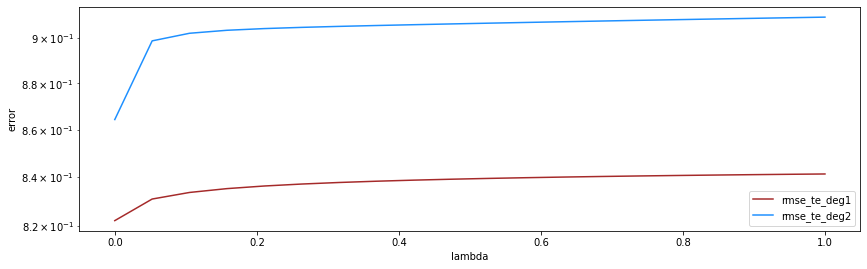

In [151]:
f = plt.figure(figsize=(14,14)) # change this if needed

#degree 1
ax1 = f.add_subplot(311)
#ax1.plot(lambdas, rmse_tr[:30], 'magenta', label="rmse_tr_deg1")
ax1.plot(lambdas, rmse_te[:20], 'brown', label="rmse_te_deg1")

#ax2 = f.add_subplot(312)
#ax1.plot(lambdas, rmse_tr[30:60], 'yellowgreen', label="rmse_tr_deg2")
ax1.plot(lambdas, rmse_te[20:], 'dodgerblue', label="rmse_te_deg2")

#ax3 = f.add_subplot(313)
#ax1.plot(lambdas, rmse_tr[60:90], 'lightskyblue', label="rmse_tr_deg3")
#ax1.plot(lambdas, rmse_te[60:90], 'k', label="rmse_te_deg3")


plt.xlabel("lambda")
plt.ylabel("error")
plt.yscale("log")
plt.legend()
plt.show()

In [314]:
seed = 656
degrees = [1]
gammas = [1.5]
steps=2000
ratio = .8

x_train, x_test, y_train, y_test = split_data(tX_hot, y, ratio, seed)

# define lists to store the loss of training data and test data
ws = []
losses_tr = []
losses_te = []

# cross validation
for degree in degrees:
    #for lambda_ in lambdas:
    for gamma in gammas:
        w = np.random.rand(tX_hot.shape[1])
        for step in range(steps):
            #loss, w = learning_by_newton_method(y_train, x_train, w, gamma)
            loss, w = learning_by_gradient_descent(y_train, x_train, w, gamma)
            losses_tr.append(loss)
            losses_te.append(calculate_loss(y_test, x_test, w))

        ws.append(w)

/home/toinou/Documents/master/ma1/ml/ml_proj1/scripts/implementations.py:228: RuntimeWarning: divide by zero encountered in log
  prediction = sigmoid(Z)
/home/toinou/Documents/master/ma1/ml/ml_proj1/scripts/implementations.py:230: RuntimeWarning: divide by zero encountered in log
  
/home/toinou/Documents/master/ma1/ml/ml_proj1/scripts/implementations.py:218: RuntimeWarning: overflow encountered in exp
  s = 1.0/(1.0 + np.exp(-t))


[0.85690593 0.81811241 0.33628391 ... 0.0701682  0.02040992 0.48772608]
[-1.94425306 -1.70436641 -0.4099008  ... -0.07275157 -0.02062108
 -0.6688958 ]
[1. 0. 0. ... 1. 0. 0.]
[-inf   0.   0. ... -inf   0.   0.]
[0. 0. 1. ... 0. 1. 1.]
[  0.   0. -inf ...   0. -inf -inf]
[1. 0. 1. ... 0. 0. 0.]
[-inf   0. -inf ...   0.   0.   0.]
[1. 0. 0. ... 1. 1. 0.]
[-inf   0.   0. ... -inf -inf   0.]
[1. 0. 0. ... 1. 0. 0.]
[-inf   0.   0. ... -inf   0.   0.]
[0. 0. 1. ... 0. 1. 1.]
[  0.   0. -inf ...   0. -inf -inf]
[1. 0. 1. ... 0. 0. 0.]
[-inf   0. -inf ...   0.   0.   0.]
[1. 0. 0. ... 1. 0. 0.]
[-inf   0.   0. ... -inf   0.   0.]
[1. 0. 0. ... 1. 0. 0.]
[-inf   0.   0. ... -inf   0.   0.]
[0. 1. 1. ... 0. 1. 1.]
[  0. -inf -inf ...   0. -inf -inf]
[1. 0. 1. ... 0. 0. 0.]
[-inf   0. -inf ...   0.   0.   0.]
[1. 0. 0. ... 1. 1. 0.]
[-inf   0.   0. ... -inf -inf   0.]
[1. 0. 0. ... 0. 0. 0.]
[-inf   0.   0. ...   0.   0.   0.]
[0. 0. 1. ... 0. 1. 0.]
[  0.   0. -inf ...   0. -inf   0.]
[1. 0. 1.

[1. 0. 0. ... 1. 0. 0.]
[-inf   0.   0. ... -inf   0.   0.]
[0. 0. 1. ... 0. 1. 1.]
[  0.   0. -inf ...   0. -inf -inf]
[1. 0. 1. ... 0. 0. 0.]
[-inf   0. -inf ...   0.   0.   0.]
[1. 0. 0. ... 0. 1. 0.]
[-inf   0.   0. ...   0. -inf   0.]
[1. 0. 0. ... 0. 0. 0.]
[-inf   0.   0. ...   0.   0.   0.]
[0. 0. 1. ... 0. 1. 1.]
[  0.   0. -inf ...   0. -inf -inf]
[1. 0. 1. ... 0. 0. 0.]
[-inf   0. -inf ...   0.   0.   0.]
[1. 0. 0. ... 0. 0. 0.]
[-inf   0.   0. ...   0.   0.   0.]
[1. 0. 0. ... 1. 0. 0.]
[-inf   0.   0. ... -inf   0.   0.]
[0. 0. 1. ... 0. 1. 1.]
[  0.   0. -inf ...   0. -inf -inf]
[1. 0. 1. ... 0. 0. 0.]
[-inf   0. -inf ...   0.   0.   0.]
[1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
 1.75227574e-07 0.00000000e+00]
[           -inf  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
 -1.75227589e-07  0.00000000e+00]
[1. 0. 0. ... 0. 0. 0.]
[-inf   0.   0. ...   0.   0.   0.]
[0. 0. 1. ... 0. 1. 1.]
[  0.   0. -inf ...   0. -inf -inf]
[1. 0. 1. ... 0. 0. 

[1. 0. 0. ... 0. 1. 0.]
[-inf   0.   0. ...   0. -inf   0.]
[1. 0. 0. ... 0. 0. 0.]
[-inf   0.   0. ...   0.   0.   0.]
[0. 0. 1. ... 0. 1. 1.]
[  0.   0. -inf ...   0. -inf -inf]
[1. 0. 1. ... 0. 0. 0.]
[-inf   0. -inf ...   0.   0.   0.]
[1. 0. 0. ... 0. 1. 0.]
[-inf   0.   0. ...   0. -inf   0.]
[1. 0. 0. ... 0. 0. 0.]
[-inf   0.   0. ...   0.   0.   0.]
[0. 0. 1. ... 0. 1. 1.]
[  0.   0. -inf ...   0. -inf -inf]
[1. 0. 1. ... 0. 0. 0.]
[-inf   0. -inf ...   0.   0.   0.]
[1. 0. 0. ... 0. 1. 0.]
[-inf   0.   0. ...   0. -inf   0.]
[1. 0. 0. ... 0. 0. 0.]
[-inf   0.   0. ...   0.   0.   0.]
[0. 0. 1. ... 0. 1. 1.]
[  0.   0. -inf ...   0. -inf -inf]
[1. 0. 1. ... 0. 0. 0.]
[-inf   0. -inf ...   0.   0.   0.]
[1. 0. 0. ... 0. 1. 0.]
[-inf   0.   0. ...   0. -inf   0.]
[1. 0. 0. ... 0. 0. 0.]
[-inf   0.   0. ...   0.   0.   0.]
[0. 0. 1. ... 0. 1. 1.]
[  0.   0. -inf ...   0. -inf -inf]
[1. 0. 1. ... 0. 0. 0.]
[-inf   0. -inf ...   0.   0.   0.]
[1. 0. 0. ... 0. 1. 0.]
[-inf   0.   0. 

KeyboardInterrupt: 

317570.8065528114
319424.7696473628


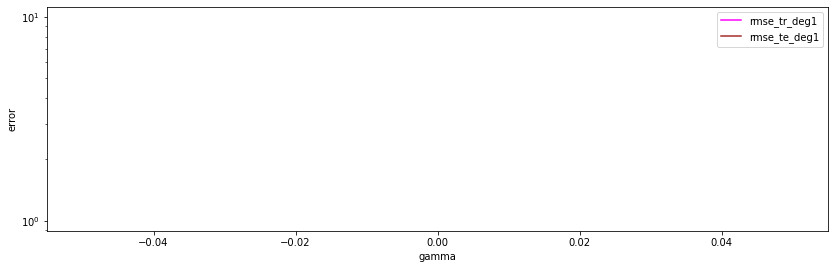

In [307]:
f = plt.figure(figsize=(14,14)) # change this if needed

print(np.sqrt(2*compute_mse(y_train,x_train,w)))
print(np.sqrt(2*compute_mse(y_test,x_test,w)))
#degree 1
ax1 = f.add_subplot(311)
ax1.plot(range(steps), losses_tr, 'magenta', label="rmse_tr_deg1")
ax1.plot(range(steps), losses_te, 'brown', label="rmse_te_deg1")

plt.xlabel("gamma")
plt.ylabel("error")
plt.yscale("log")
plt.legend()
plt.show()

In [310]:
print(losses_te)

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

In [220]:
loss,weights = ridge_regression(y, build_poly(tX_hot,2), 0.75)

In [221]:
print(tX_hot.shape[1])
print(len(weights))
print(weights)
print(loss)

33
67
[-0.02881102  0.02839658 -0.09620074  0.01582389  0.02994869  0.01897818
  0.01551189 -0.01681681  0.03502173 -0.00520658  0.02453951 -0.04923816
  0.055845    0.0322811   0.06126586 -0.00014922 -0.00076271 -0.00134555
  0.00035609  0.00021221 -0.00692964  0.00146511  0.01689059  0.00538524
  0.02215877  0.00029284  0.00062506  0.00316131  0.00043526 -0.00082017
 -0.01437147  0.          0.          0.         -0.01216517  0.00737225
 -0.00540085  0.01863263  0.0177559   0.00118585  0.00065214 -0.05290048
 -0.00304813 -0.00399403  0.00065838  0.0008476   0.0077674  -0.0020547
 -0.04020606 -0.02433755  0.00155005 -0.05186904 -0.02601186  0.00214445
 -0.0228176  -0.01901872 -0.03734142 -0.00584636  0.02883954 -0.02068768
  0.00119158  0.01426812 -0.00631553 -0.01437147  0.          0.
  0.        ]
0.34899460689176715


## Least_squares_DG

## Least_squares_SDG
Ne donne que des loss = nan, le calcul du gradient ne se passe pas bien, que ça soit avec les rows contenant du -999 ou pas.

## Least_square
degree 1 -> -334.4 (mse loss)

## Ridge_regression
Seems the most suited since we have so many features. Maybe we could remove some features if they are highly correlated (might be visible on plots?
degree = 6 -> singular matrix

## Logistic_regression
Since we have a binary output, it might be the best option...

## Reg_logistic_regression

# Remarks
if degree = 3, 7, ...
-> LinAlgError: Singular matrix



# TODO
- plot all the variable with boxplot
- compute ,np.cov between the variables
- compute Pearson correlation np.cov(x,y)/(std(x) * std(y))

In [ ]:
def predict_labels(w, x):
    return 1

## Generate predictions and save ouput in csv format for submission:

In [180]:
DATA_TEST_PATH = '/home/toinou/course/ml/ml_proj1/data/test.csv'
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [181]:
OUTPUT_PATH = '/home/toinou/course/ml/ml_proj1/sub6.csv'
tX_test.T[[22, -1]] = tX_test.T[[-1, 22]]
tX_test_hot = one_hot_jet_num(clean(standardize(tX_test)))
tX_test_hot = build_poly(tX_test_hot,2)
y_pred = predict_labels(weights, tX_test_hot)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

In [121]:
weights

array([-7.53225415e-03,  2.53940620e-04, -9.08223071e-03, -2.12791035e-03,
       -2.21631010e-03, -1.27817484e-03,  5.50923985e-04, -9.85283433e-03,
        1.88673236e-02,  5.48501086e-05,  3.06728169e-03, -2.00786362e-02,
        3.78874608e-02,  8.31814806e-03,  6.25395724e-03, -6.13018578e-04,
       -1.08780006e-03,  2.37444582e-03, -9.39576560e-04,  1.05833265e-03,
        4.94737608e-03,  7.16301000e-04, -7.86342456e-04, -5.56063433e-03,
        1.63376716e-03, -8.09613631e-04, -6.88979545e-04,  9.23605741e-05,
        1.87868848e-03,  4.48825670e-04,  2.79801857e-06, -5.35682988e-06,
       -2.15119070e-03, -5.37850464e-03])

In [ ]:
tX_test_hot

In [160]:
print(tX.shape[1])
print(tX_hot.shape[1])
print(tX_test.shape[1])
print(tX_test_hot.shape[1])
print("***")
print(len(weights))

30
33
30
33
***
33


In [172]:
print(tX_test_hot[:,-5:])
print(tX_test_hot.shape[0])
print(tX_test_hot.shape[1])
print(tX_hot.shape[0])
print(build_poly(tX_hot,2)[:,-5:])

[[9.98001e+05 1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [9.98001e+05 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00]
 [9.98001e+05 1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 ...
 [9.98001e+05 1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [9.98001e+05 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00]
 [9.98001e+05 1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]]
568238
67
250000
[[6.125625e+00 0.000000e+00 0.000000e+00 1.000000e+00 0.000000e+00]
 [9.980010e+05 0.000000e+00 1.000000e+00 0.000000e+00 0.000000e+00]
 [9.980010e+05 0.000000e+00 1.000000e+00 0.000000e+00 0.000000e+00]
 ...
 [9.980010e+05 0.000000e+00 1.000000e+00 0.000000e+00 0.000000e+00]
 [9.980010e+05 1.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.980010e+05 1.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]]


## Submissions

1. ridge, degree 2, lambdas = 0.75 -> 0.752
2. ridge, degree 1, lambdas = 0.75 -> 0.732
3. logreg, degree 1, lambda = 0.75 -> 0.662

implementation of normalization and hot one

4. ridge, degree 1, lambdas = 0.69 -> 0.752
5. ridge, degree 2, lambdas = 0.69 -> 0.732
6. logreg, degree 1, gamma ?       -> (random start, 3000 steps)